****
# MongoDB, Numpy and Scikit-learn
****

## About this notebook: 
Notebook prepared by **Jesus Perez Colino** Version 0.1, First Released: 01/12/2014, Alpha.  

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: This notebook contains a brief introduction to **MongoDB** and **PyMongo**, and the basic code to use it to store **Numpy** input/output for a **Scikit-learn** regression model. 


- **Python & packages versions** to reproduce the results of this notebook: 

In [1]:
from datetime import datetime, timedelta
import pymongo
import scrapy
from sys import version
from pymongo import MongoClient
print ' Reproducibility conditions for this notebook '.center(90,'-')
print 'Python version:       ' + version
print 'Pymongo version:      ' + pymongo.version
print 'Scrapy version:       ' + scrapy.__version__
print '-'*90

---------------------- Reproducibility conditions for this notebook ----------------------
Python version:       2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Sep 15 2015, 14:29:08) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Pymongo version:      3.0.3
Scrapy version:       0.20.2
------------------------------------------------------------------------------------------


## Basics about MongoDB with PyMongo

MongoDB is a *document-oriented database*, not a relational one. This is different from a relational database in two significant ways. Firstly, not all entries must adhere to the same schema. Secondly you can embed entries inside of one another. The primary reason for moving away from the relational model is to make *scaling* out easier, but there are some other advantages as well. 

Basically, a *document-oriented database* replaces the concept of a *“row”* with a more flexible model, the *“document”*. By allowing embedded documents and arrays, the document- oriented approach makes it possible to represent complex hierarchical relationships with a single record. This fits naturally into the way developers in modern object-oriented languages think about their data. 

**Documents** in MongoDB are modeled after the `JSON` (JavaScript Object Notation) format, but are actually stored in `BSON` (Binary JSON). Briefly, what this means is that a MongoDB document is *a dictionary of key-value pairs*, where the value may be one of a number of types:

- Primitive JSON types (e.g., number, string, Boolean)
- Primitive BSON types (e.g., datetime, ObjectId, UUID, regex)
- Arrays of values
- Objects composed of key-value pairs
- Null

MongoDB creates **databases** and **collections** automatically if they don't exist already. A single instance of MongoDB *can support multiple independent databases*. 


Let's first, open a connection with the MondoDB server:

In [2]:
try: 
    client = MongoClient("localhost", 27017)
    print "Connected to MongoDB as:", client
except pymongo.errors.ConnectionFailure, e:
    print "Could not connect to MongoDB: %s" % e 

Connected to MongoDB as: MongoClient('localhost', 27017)



When working with PyMongo you access databases using attribute style access:

In [3]:
db = client.test_database
print db

Database(MongoClient('localhost', 27017), u'test_database')


A **collection** is a *group of documents* stored in MongoDB, and can be thought of as roughly the equivalent of a table in a relational database. 

In [4]:
# to prevent colision cases in db with previous db connetions: 

for name in db.collection_names():
    if name != 'system.indexes':
        db.drop_collection(name)

db.collection_names()

[u'system.indexes']

In terms of syntax, getting a collection in PyMongo works the same as getting a database:

In [5]:
db.create_collection("test")

document = {"x": "jpcolino", "tags": ["author", "developer", "tester"]}

db.test.insert_one(document)

In [6]:
print '-'*75
print 'Databases open in client: ', client.database_names()
print 'Collection names in db:   ', db.collection_names()
print '-'*75

---------------------------------------------------------------------------
Databases open in client:  [u'local', u'test_database']
Collection names in db:    [u'system.indexes', u'test']
---------------------------------------------------------------------------


MongoDB is sometimes referred to as a *“schemaless” database*, meaning that it does not enforce a particular structure on documents in a collection. It means that it is perfectly possible to store every object in your application in the same collection, regardless of its structure. Or in other words, *collections have dynamic schemas*. This means that the documents within a single collection can have any number of different “shapes.” For example, the following five documents could be stored in a single collection:

In [7]:
result = db.test.insert_many([{"x": 1, "tags": ["dog", "cat"]},
                              {"x": 2, "tags": ["cat"]},
                              {"x": 2, "tags": ["mouse", "cat", "dog"]},
                              {"x": 3, "tags": []},
                              {"y": 4, "tags": 123456}])

Note that the previous documents not only have different types for their values (string versus integer) but also have entirely different keys.

Because any document can be put into any collection, the question often arises: “Why do we need separate collections at all?” It’s a good question—with no need for separate schemas for different kinds of documents, why should we use more than one collection? There are several good reasons:

- Keeping different kinds of documents in the same collection can be a nightmare for developers and admins.
- It is much faster to get a list of collections than to extract a list of the types in a collection. 
- Grouping documents of the same kind together in the same collection allows for data locality.
- We begin to impose some structure on our documents when we create indexes. 
As you can see, there are sound reasons for creating a schema and for grouping related types of documents together, even though MongoDB does not enforce it.

Therefore, it is clear that it will be more frequent the case that a collection will contain documents of identical, or closely related, structure. When all the documents in a collection are similarly, but not identically, structured, we call this a **polymorphic schema**.

MongoDB stores documents contiguously on disk, putting all the data you need into one document means that you’re never more than one seek away from everything you need.

## Basic operations with a document

In [8]:
# Updating a document with $rename

db.test.update_one({"y": 4},{"$rename": {"y":"x"}})

In [9]:
for doc in db.test.find():
    print doc

{u'x': u'jpcolino', u'_id': ObjectId('562f562dc47fab06d8a14eb5'), u'tags': [u'author', u'developer', u'tester']}
{u'x': 1, u'_id': ObjectId('562f562dc47fab06d8a14eb6'), u'tags': [u'dog', u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb7'), u'tags': [u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb8'), u'tags': [u'mouse', u'cat', u'dog']}
{u'x': 3, u'_id': ObjectId('562f562dc47fab06d8a14eb9'), u'tags': []}
{u'x': 4, u'_id': ObjectId('562f562dc47fab06d8a14eba'), u'tags': 123456}


In [10]:
# Deleting a document with delete_one

db.test.delete_one({'x':'jpcolino'})

for doc in db.test.find():
    print doc

{u'x': 1, u'_id': ObjectId('562f562dc47fab06d8a14eb6'), u'tags': [u'dog', u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb7'), u'tags': [u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb8'), u'tags': [u'mouse', u'cat', u'dog']}
{u'x': 3, u'_id': ObjectId('562f562dc47fab06d8a14eb9'), u'tags': []}
{u'x': 4, u'_id': ObjectId('562f562dc47fab06d8a14eba'), u'tags': 123456}


We can insert in a collection a document as a dict coming directly from an instance of a Python class:

In [11]:
import bson

class Example(object):
    def __init__(self):
        self.a = 'a'
        self.b = 'b'
    def set_c(self, c):
        self.c = c
        
        
e = Example()
e.__dict__

{'a': 'a', 'b': 'b'}

In [12]:
e.set_c(123)
e.__dict__

{'a': 'a', 'b': 'b', 'c': 123}

In [13]:
db.test.insert_one(e.__dict__)

In [14]:
for doc in db.test.find():
    print doc

{u'x': 1, u'_id': ObjectId('562f562dc47fab06d8a14eb6'), u'tags': [u'dog', u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb7'), u'tags': [u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb8'), u'tags': [u'mouse', u'cat', u'dog']}
{u'x': 3, u'_id': ObjectId('562f562dc47fab06d8a14eb9'), u'tags': []}
{u'x': 4, u'_id': ObjectId('562f562dc47fab06d8a14eba'), u'tags': 123456}
{u'a': u'a', u'c': 123, u'_id': ObjectId('562f562dc47fab06d8a14ebb'), u'b': u'b'}


In [15]:
db.test.delete_one({'a':'a'})

In [16]:
for doc in db.test.find():
    print doc

{u'x': 1, u'_id': ObjectId('562f562dc47fab06d8a14eb6'), u'tags': [u'dog', u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb7'), u'tags': [u'cat']}
{u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb8'), u'tags': [u'mouse', u'cat', u'dog']}
{u'x': 3, u'_id': ObjectId('562f562dc47fab06d8a14eb9'), u'tags': []}
{u'x': 4, u'_id': ObjectId('562f562dc47fab06d8a14eba'), u'tags': 123456}


In [17]:
# Retriving basic information over the collection:

print 'Name of the Database: \n', db.test.name
print '-'*75
print 'Full descriptions: \n', db.test.acknowledged
print '-'*75
for ids in result.inserted_ids:
    print 'ObjectID: ', ids
print '-'*75
for i, doc in enumerate(db.test.find()[1:]):
    print 'Doc {0}: {1}'.format(i, doc)
print '-'*75


Name of the Database: 
test
---------------------------------------------------------------------------
Full descriptions: 
Collection(Database(MongoClient('localhost', 27017), u'test_database'), u'test.acknowledged')
---------------------------------------------------------------------------
ObjectID:  562f562dc47fab06d8a14eb6
ObjectID:  562f562dc47fab06d8a14eb7
ObjectID:  562f562dc47fab06d8a14eb8
ObjectID:  562f562dc47fab06d8a14eb9
ObjectID:  562f562dc47fab06d8a14eba
---------------------------------------------------------------------------
Doc 0: {u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb7'), u'tags': [u'cat']}
Doc 1: {u'x': 2, u'_id': ObjectId('562f562dc47fab06d8a14eb8'), u'tags': [u'mouse', u'cat', u'dog']}
Doc 2: {u'x': 3, u'_id': ObjectId('562f562dc47fab06d8a14eb9'), u'tags': []}
Doc 3: {u'x': 4, u'_id': ObjectId('562f562dc47fab06d8a14eba'), u'tags': 123456}
---------------------------------------------------------------------------


Here, we have some **query operators**: 

In [18]:
print 'Number of Documents: ', db.test.count()
print '-'*75
print "Number of Documents with field 'x':",db.test[{'x': 2}]
print '-'*75
print 'Number of Documents where x == 2: ', db.test.find({'x': 2}).count()
print '-'*75
print 'Number of Documents with x >= 2: ', db.test.find({'x':{'$gte': 2}}).count()
print '-'*75
# print 'Number of Documents with x >= 2: ', db.test[$not'x'].find().count()

Number of Documents:  5
---------------------------------------------------------------------------
Number of Documents with field 'x': Collection(Database(MongoClient('localhost', 27017), u'test_database'), u"test.{'x': 2}")
---------------------------------------------------------------------------
Number of Documents where x == 2:  2
---------------------------------------------------------------------------
Number of Documents with x >= 2:  4
---------------------------------------------------------------------------


Queries can also use special query operators. These operators include **gt, gte, lt, lte, ne, nin, regex, exists, not, or**, and many more. 

Additionally we can use **regular expresions**: 

In [19]:
# Using Regex to find tags = cats

import re
regex = re.compile(r'cat')
rstats = db.test.find({"tags":regex}).count()
print 'Number of Documents where you will find a "cat": ', rstats

Number of Documents where you will find a "cat":  3


In [20]:
from pymongo import DESCENDING
db.test.drop_indexes()
db.test.create_index([("x", pymongo.DESCENDING)], name = "id_x")

'id_x'

In [21]:
print db.test.index_information() 
for doc in db.test.index_information() :
    print doc

{u'id_x': {u'ns': u'test_database.test', u'key': [(u'x', -1)], u'v': 1}, u'_id_': {u'ns': u'test_database.test', u'key': [(u'_id', 1)], u'v': 1}}
id_x
_id_


## Statistical Modelling and MongoDB

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [23]:
# X is the 10x10 Hilbert matrix (Numpy matrix)
# y is a Numpy array

X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

In [24]:
X

array([[ 1.        ,  0.5       ,  0.33333333,  0.25      ,  0.2       ,
         0.16666667,  0.14285714,  0.125     ,  0.11111111,  0.1       ],
       [ 0.5       ,  0.33333333,  0.25      ,  0.2       ,  0.16666667,
         0.14285714,  0.125     ,  0.11111111,  0.1       ,  0.09090909],
       [ 0.33333333,  0.25      ,  0.2       ,  0.16666667,  0.14285714,
         0.125     ,  0.11111111,  0.1       ,  0.09090909,  0.08333333],
       [ 0.25      ,  0.2       ,  0.16666667,  0.14285714,  0.125     ,
         0.11111111,  0.1       ,  0.09090909,  0.08333333,  0.07692308],
       [ 0.2       ,  0.16666667,  0.14285714,  0.125     ,  0.11111111,
         0.1       ,  0.09090909,  0.08333333,  0.07692308,  0.07142857],
       [ 0.16666667,  0.14285714,  0.125     ,  0.11111111,  0.1       ,
         0.09090909,  0.08333333,  0.07692308,  0.07142857,  0.06666667],
       [ 0.14285714,  0.125     ,  0.11111111,  0.1       ,  0.09090909,
         0.08333333,  0.07692308,  0.07142857

In [25]:
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

#### 1. Storing Numpy objects in MongoDB: arrays and matrices



In [26]:
from bson.binary import Binary
import cPickle

In [27]:
collection = db.test_database.np_inputs

In [28]:
# cleaning db before to store anything:

for name in db.collection_names():
    if name != 'system.indexes':
        db.drop_collection(name)

db.collection_names()

[u'system.indexes']

In [29]:
inputs = {}
inputs['X'] = Binary( cPickle.dumps( X, protocol=2) ) # Using cPickle with fast protocol=2.
inputs['y'] = y.tolist()

db.collection.insert_one({'inputs': inputs })

Notice that we have stored the numpy matrix in a `Binary` form using `cPickle` (faster than `pickle`), and therefore, we have to decode later to load or retrive the matrix (see next section)

In [30]:
for i, doc in enumerate(db.collection.find()):
    print 'Doc {0}: \n {1}'.format(i, doc)

Doc 0: 
 {u'inputs': {u'y': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], u'X': Binary('\x80\x02cnumpy.core.multiarray\n_reconstruct\nq\x01cnumpy\nndarray\nq\x02K\x00\x85U\x01b\x87Rq\x03(K\x01K\nK\n\x86cnumpy\ndtype\nq\x04U\x02f8K\x00K\x01\x87Rq\x05(K\x03U\x01<NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tb\x89T \x03\x00\x00\x00\x00\x00\x00\x00\x00\xf0?\x00\x00\x00\x00\x00\x00\xe0?UUUUUU\xd5?\x00\x00\x00\x00\x00\x00\xd0?\x9a\x99\x99\x99\x99\x99\xc9?UUUUUU\xc5?\x92$I\x92$I\xc2?\x00\x00\x00\x00\x00\x00\xc0?\x1c\xc7q\x1c\xc7q\xbc?\x9a\x99\x99\x99\x99\x99\xb9?\x00\x00\x00\x00\x00\x00\xe0?UUUUUU\xd5?\x00\x00\x00\x00\x00\x00\xd0?\x9a\x99\x99\x99\x99\x99\xc9?UUUUUU\xc5?\x92$I\x92$I\xc2?\x00\x00\x00\x00\x00\x00\xc0?\x1c\xc7q\x1c\xc7q\xbc?\x9a\x99\x99\x99\x99\x99\xb9?F\x17]t\xd1E\xb7?UUUUUU\xd5?\x00\x00\x00\x00\x00\x00\xd0?\x9a\x99\x99\x99\x99\x99\xc9?UUUUUU\xc5?\x92$I\x92$I\xc2?\x00\x00\x00\x00\x00\x00\xc0?\x1c\xc7q\x1c\xc7q\xbc?\x9a\x99\x99\x99\x99\x99\xb9?F\x17]t\xd1E\xb7?UUUUUU\xb5?\x00\

#### 2. Loading the data from the MongoDB collection

In [39]:
for doc in db.collection.find():
    if isinstance(doc.get(u'inputs'),dict):
        inputs = doc.get(u'inputs')
        y = inputs.get(u'y')
        X = np.hstack([cPickle.loads(inputs.get(u'X'))]) 

# Display of data retrived: 

print '-'*65
print 'y data stored as:', type(y)
print 'y: \t', y
print '-'*65
print 'X data stored as:', type(X)
print 'X: \n',X
print '-'*65

-----------------------------------------------------------------
y data stored as: <type 'list'>
y: 	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
-----------------------------------------------------------------
X data stored as: <type 'numpy.ndarray'>
X: 
[[ 1.          0.5         0.33333333  0.25        0.2         0.16666667
   0.14285714  0.125       0.11111111  0.1       ]
 [ 0.5         0.33333333  0.25        0.2         0.16666667  0.14285714
   0.125       0.11111111  0.1         0.09090909]
 [ 0.33333333  0.25        0.2         0.16666667  0.14285714  0.125
   0.11111111  0.1         0.09090909  0.08333333]
 [ 0.25        0.2         0.16666667  0.14285714  0.125       0.11111111
   0.1         0.09090909  0.08333333  0.07692308]
 [ 0.2         0.16666667  0.14285714  0.125       0.11111111  0.1
   0.09090909  0.08333333  0.07692308  0.07142857]
 [ 0.16666667  0.14285714  0.125       0.11111111  0.1         0.09090909
   0.08333333  0.07692308  0.07142857  0.06666667

#### 3. Running a Ridge-regression model

In [40]:
from sklearn import linear_model

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

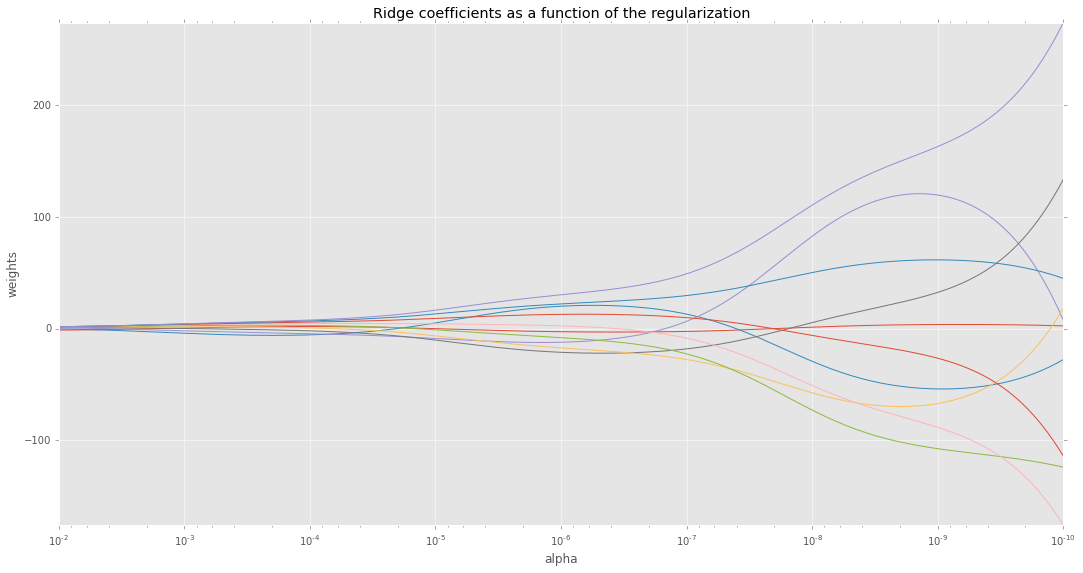

In [41]:
# Display results
%matplotlib inline
plt.figure(num=None, figsize=(18, 9))
plt.style.use('ggplot')

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight');

#### 4. Storing model results in MongoDB

In [42]:
outputs = {}
outputs['coefs'] = Binary( cPickle.dumps( coefs, protocol=2) ) # Using cPickle with fast protocol=2
db.collection.insert_one({'outputs': outputs} )

#### 5. Retriving results stored from the database